# Background



In this exercise, we implement the concept of structural stochastic volatility which derives from different noise levels in the demand of fundamentalist and chartists and time varying market share of the two groups. 

We consider the || name here || approach of endogenous switching between the trading strategies and estimate the model by method of simulated moments. where choice of moments reflects the basic stylized facts of daily returns of a stock market index. 

In [41]:
import time
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import acf
from yahoofinancials import YahooFinancials
import scipy.optimize as opt
from arch import arch_model
from scipy.stats import kurtosis, skew
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
import os, pickle as pkl
plt.rcParams['figure.figsize'] = (15, 6)


In [83]:
class DataLoader:
    def __init__(self, assets, start_date, end_date, frequency='daily'):
        self.assets = assets
        self.start_date = start_date
        self.end_date = end_date
        self.frequency = frequency
        
    
    def get_empirical_data(self, log_returns = True, commentary=True):
        yahoo_financial = YahooFinancials(self.assets)
        try:
            data = yahoo_financial.get_historical_price_data(start_date=self.start_date,
                                                             end_date=self.end_date,
                                                             time_interval=self.frequency)
            df = pd.DataFrame({
            a: {x['formatted_date']: x['adjclose'] for x in data[a]['prices']} for a in assets
        })
        except:
            print("Not able to download data using yahoo financials. System will exit here.")
            sys.exit(0)
            
        df = df.set_index(pd.DatetimeIndex(df.index))
        
        if log_returns:
            df = np.log(df / df.shift(1)).dropna()
            
        if commentary:
            print("Data extraction successful....\nSummary: \n\n", df.describe())
            
        return df
    

    

    
class Moments:
    def __init__(self):
        pass
    def get_numerical_moments(self, series, moment_list, averaging_offset=None):
        if averaging_offset is None:
            moment_max = np.max(moment_list)
        else:
            moment_max = np.max(moment_list) + averaging_offset
        
        autocorr = acf(series, unbiased=True, nlags=moment_max, fft=False)
        
        results = []
        
        if averaging_offset is None:
            results = [autocorr[moment] for moment in moment_list]
        else:
            results = [np.mean(autocorr[1:3]) if moment==1 \
                       else np.mean(autocorr[moment-averaging_offset:moment + averaging_offset+1])\
                      for moment in moment_list]
    
        return results
    
    def get_hill_estimator(self, series, k=0.05):
        abs_series = np.sort(np.abs(series))
        num_terms = int(k*len(abs_series))
        gamma = np.mean(np.log(abs_series[-num_terms:])) - abs_series[-(num_terms+1)]
        return 1.0/gamma
    
    
class HPM:
    HPM_INIT = {
                    "mu": 0.01, 
                    "phi": 0.12,
                    "chi": 1.5,
                    #"eta": 0,
#                     "alpha_w": 0,
#                     "alpha_O": -0.327,
#                     "alpha_p": 18.43,
#                     "alpha_n": 1.79,
                    "sigma_f": 0.758,
                    "sigma_c": 2.087
                }
    
    def __init__(self):
#         self.special_print = True
        pass
        
    def optimise_criterion(self, params_dict_values, *args):
        (ts, weighing_matrix, keys) = args 
        params_dict = {keys[i]:params_dict_values[i] for i in range(len(keys))}
        actual_ts_moments, _ = self.get_moments(ts)
        simulated_price = self.simulate(params_dict, 1)#, length=5*len(ts))
        simulated_price_returns = np.log(simulated_price[1:, :]) - np.log(simulated_price[:-1, :])
        simulated_ts_moments, _ = self.get_moments(simulated_price_returns[:, 0].flatten())
        
        error = np.array(actual_ts_moments).reshape(1, -1) - np.array(simulated_ts_moments).reshape(1, -1)
#         if self.special_print:
#             print((error @ weighing_matrix @ error.T).shape)
#             self.special_print = False
        return (error @ weighing_matrix @ error.T).flatten()[0]
    
    def calibrate(self, initial_params_dict, ts, weighing_matrix, n_max_iter=1000):
        keys, values = list(initial_params_dict.keys()), tuple(initial_params_dict.values())
        calibrated_result = opt.minimize(self.optimise_criterion, values, args=(ts, weighing_matrix, keys),\
                                        method='Nelder-Mead', options={'maxiter': n_max_iter, 'disp': True})
        calibrated_params = {keys[i]:calibrated_result.x[i] for i in range(len(keys))}
        return calibrated_params
        
    def get_moments(self, ts):
        '''
        Returns the moments in the following order:
        ['Lag 1 autocorrelation from raw returns', 'Mean absolute level', 'Lag 1 autocorrelation from abs returns',
        'Lag 5 autocorrelation from abs returns', 'Lag 10 autocorrelation from abs returns', 
        'Lag 25 autocorrelation from abs returns', 'Lag 50 autocorrelation from abs returns',
        'Lag 100 autocorrelation from abs returns', 'Hill estimator']
        '''
        mom_obj = Moments()
        
        m = []
        
        abs_ts = np.abs(ts)
        
        
        # First order autocorrelation coefficient from raw returns
        m = m + mom_obj.get_numerical_moments(ts, [1])
        
        # Mean of absolute returns 
        m = m + [np.mean(abs_ts)]
        
        # Hill estimator 
        m = m + [mom_obj.get_hill_estimator(abs_ts)]
        
        # lag [1,5] from absolute returns 
        m = m + mom_obj.get_numerical_moments(abs_ts, [1, 5, 10, 25, 50, 100], averaging_offset=1)
        
        return m, ['Lag 1 autocorrelation raw time series', 
                   'Mean of absolute time series', 
                   'Hill estimator of absolute time series', 
                   'Lag 1 autocorrelation of absolute time series', 
                  'Lag 5 autocorrelation of absolute time series', 
                   'Lag 10 autocorrelation of absolute time series',
                   'Lag 25 autocorrelation of absolute time series', 
                  'Lag 50 autocorrelation of absolute time series' , 
                   'Lag 100 autocorrelation of absolute time series']
        
        
        
        
        
    
    
    def get_weighing_matrix(self, actual_ts, num_bootstraps=5000,  method = 'block-bootstrap'):
        
        if method.lower() =='block-bootstrap':
            
            moment_samples = np.zeros((9, num_bootstraps))
            abs_ts = np.abs(actual_ts)
            
            num_blocks_250 = len(actual_ts) // 250
            num_blocks_750 = len(actual_ts) // 750
            
            for i in range(num_bootstraps):
                
                m = []
                
                # numeric_moments_absolute lags = [1, 5, 10, 25, 100]
                modified_ts = np.array([])
                
                for j in range(num_blocks_250):
                    slice_start = np.random.randint(num_blocks_250)*250
                    modified_ts = np.append(modified_ts, actual_ts[slice_start:slice_start+250])
                
                
                m = self.get_moments(modified_ts)[0][:-4]
                
                
                
                modified_abs_ts = []
                
                for j in range(num_blocks_750):
                    slice_start = np.random.randint(num_blocks_750)*750
                    modified_abs_ts = np.append(modified_abs_ts, abs_ts[slice_start:slice_start+750])
            
                m = m + self.get_moments(modified_abs_ts)[0][-4:]
                moment_samples[:, i] = m
                
            weighing_matrix = np.linalg.inv(np.cov(moment_samples))
            
        return weighing_matrix
    
        
    
    def simulate(self, param_dict, num_paths, pstar = None, length=1000, price0=100):
            
        if pstar is None:
            pstar = 0
            
        
        price = np.zeros((length+1, num_paths))
        demand_fundamentalist = np.zeros((length+1, num_paths))
        demand_chartist = np.zeros((length+1, num_paths))
        num_chartist = np.ones((length+1, num_paths))*0.5
        num_fundamentalist = np.ones((length+1, num_paths))*0.5
        
        price[0, :] = np.array([price0]*num_paths)
        
        for t in range(1, length+1):
            price[t, :] = price[t-1, :] + param_dict['mu']*(num_fundamentalist[t-1, :]*demand_fundamentalist[t-1, :] \
                                                     + num_chartist[t-1, :]*demand_chartist[t-1, :])
            
            demand_fundamentalist[t, :] = param_dict['phi']*(pstar - price[-1,:]) \
                                        + np.random.normal(scale= param_dict['sigma_f'], size=num_paths)
            demand_chartist[t, :] = param_dict['chi']*(price[t]-price[t-1]) \
                                        + np.random.normal(scale= param_dict['sigma_c'], size=num_paths)
            
            
        return price
            
        
        
        
        
    
    
    
    
    

## Fetch the data 

In [84]:
assets = ['^GSPC']
assets_dict = {'^GSPC':'SPX'}
start_date = '1979-12-31'
end_date = '2020-07-29'
frequency = 'daily'



dl = DataLoader(assets, start_date, end_date, frequency=frequency)
df = dl.get_empirical_data(log_returns=False)

df_returns = (np.log(df) - np.log(df.shift(1))).dropna()

Data extraction successful....
Summary: 

               ^GSPC
count  10232.000000
mean    1027.420476
std      777.388608
min       98.220001
25%      333.962494
50%     1006.740021
75%     1390.694946
max     3386.149902


***** Running HPM for ^GSPC *****
Reading weighing matrix ....
Weighing matrix read ....
Calibrating ....
Calibration done....
Total time to calibrate in seconds 163.21476006507874
Simulating prices ....
Calibration done....
Total time to simulate in seconds 9.45662784576416
Calculating moments from simulated prices ....
Calculation of moments done ....
Total time to calculated moments from simulated scenarios in seconds 1129.3864059448242


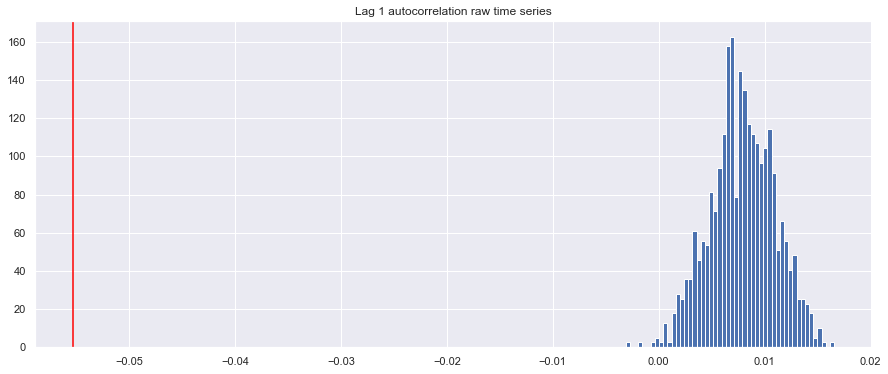

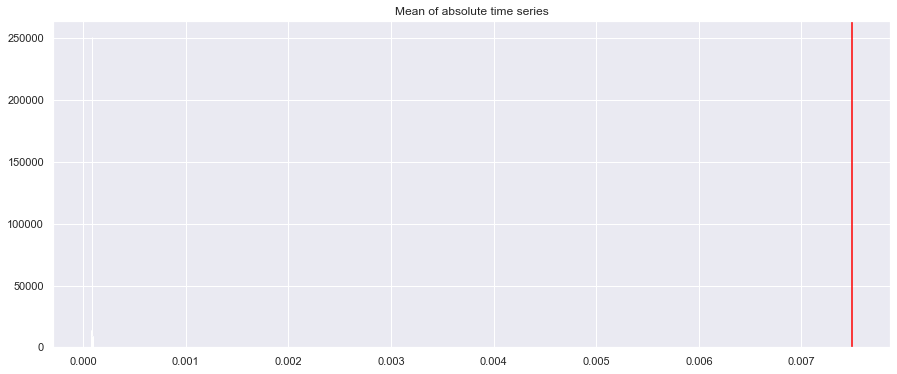

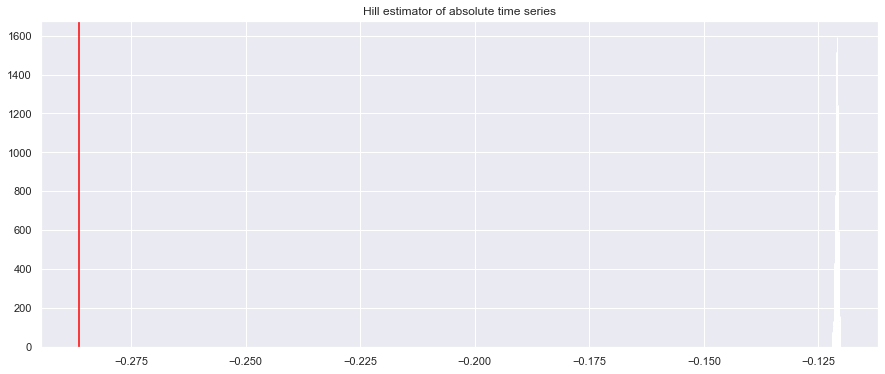

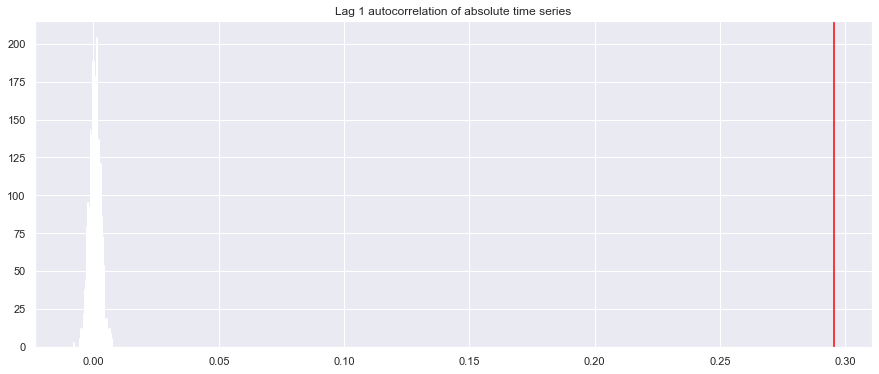

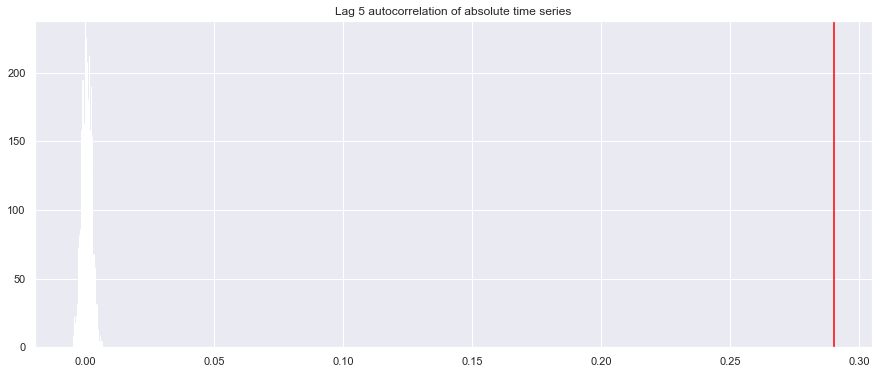

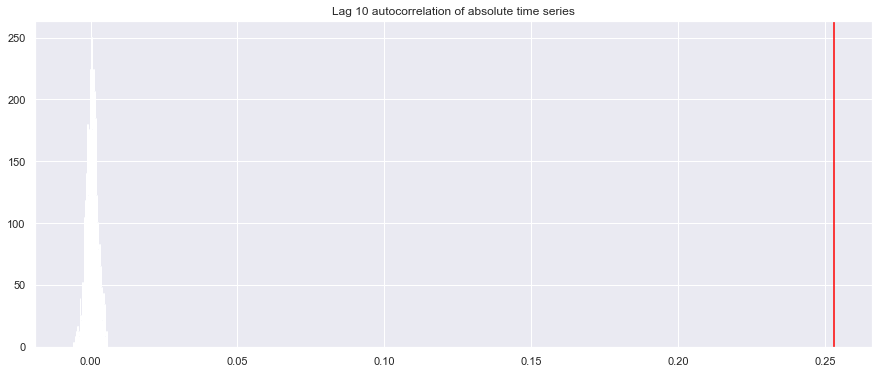

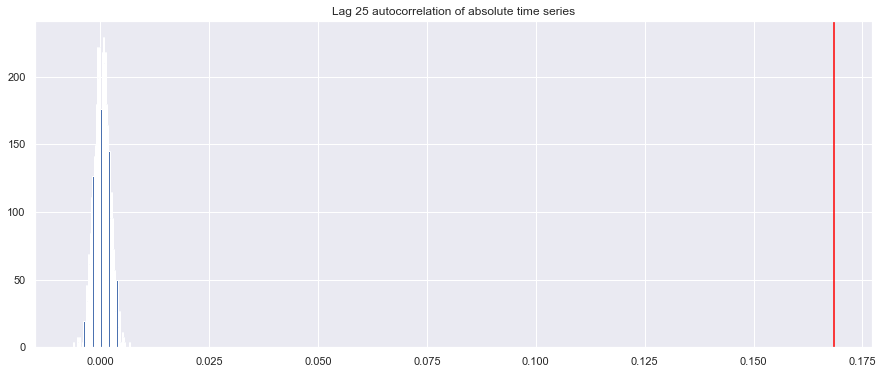

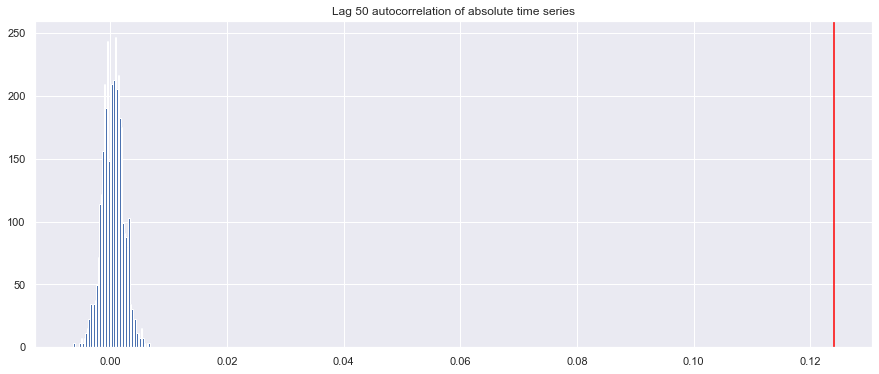

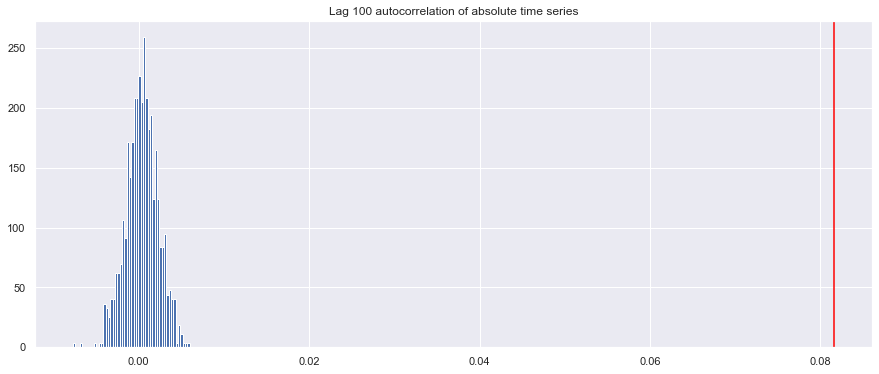

In [86]:
weighing_matrix_filename = 'weighing_matrix-'+start_date+'-to-'+end_date + '.pkl'
load = True
num_bootstraps = 5000
keys, values = HPM.HPM_INIT.keys(), HPM.HPM_INIT.values()
num_paths = 1000


for asset in assets:
    print("*"*5, "Running HPM for", asset, "*"*5)
    hpm_obj = HPM()
    
    # Read/generate weighing matrix
    if load and os.path.isfile(weighing_matrix_filename):
        print("Reading weighing matrix ....")
        with open(weighing_matrix_filename, 'rb') as file_obj:
            weighing_matrix = pkl.load(file_obj)
        print("Weighing matrix read ....")
    else: 
        print("Generating weighing matrix....")
        start = time.time()
        weighing_matrix = hpm_obj.get_weighing_matrix(df_returns[[asset]].values.flatten(),\
                                                      num_bootstraps=num_bootstraps)
        print("Weighing matrix generated ....")
        print("Total time taken to calculate weighing matrix in seconds", time.time()-start)
        
        if not os.path.isfile(weighing_matrix_filename):
            with open(weighing_matrix_filename, 'wb') as file_obj:
                pkl.dump(weighing_matrix, file_obj)
            
    print("Calibrating ....")
    start = time.time()
    calibrated_params = hpm_obj.calibrate(initial_params_dict = HPM.HPM_INIT, 
                                          ts = df_returns[[asset]].values.flatten(), 
                                          weighing_matrix = weighing_matrix)
    print("Calibration done....")
    print("Total time to calibrate in seconds", time.time()-start)
    
    print("Simulating prices ....")
    start = time.time()
    price_simulated = hpm_obj.simulate(calibrated_params, num_paths=num_paths, length=10*len(df[asset]))
    print("Calibration done....")
    print("Total time to simulate in seconds", time.time()-start)
    
    
    returns_simulated = (np.log(price_simulated[1:, :]) - np.log(price_simulated[:-1, :]))
    
    print("Calculating moments from simulated prices ....")
    start = time.time()
    moments_simulated = [hpm_obj.get_moments(returns_simulated[:, i])[0] for i in range(num_paths)]
    print("Calculation of moments done ....")
    print("Total time to calculated moments from simulated scenarios in seconds", time.time()-start)
    
    moments_actual, headers = hpm_obj.get_moments(df_returns[[asset]].values.flatten())
    moments_simulated_df = pd.DataFrame(np.array(moments_simulated), columns=headers)
    
    for header in headers:
        fig, ax = plt.subplots()
        ax.hist(moments_simulated_df[header], density=True, bins=50)
        ax.axvline(moments_actual[headers.index(header)], color='red')
        plt.title(header)
        plt.show()
    
    
    
    

In [76]:
hist_axes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9903b4be90>],
      dtype=object)